# Mounting google drive : 
The trained model weights will be saved here.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -q
!unzip -qq /content/tiny-imagenet-200.zip

# Train and test data loaders

In [3]:
import torch
from tiny_imagenet_data_loader import get_train_validation_test_data_loaders

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
data_dir = r"/content/tiny-imagenet-200"
train_loader, val_loader, classes = get_train_validation_test_data_loaders(data_dir, batch_size, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


n04251144 n03355925 n02699494 n01855672


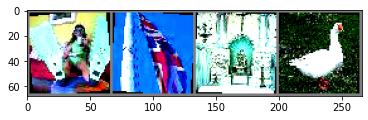

In [4]:
import numpy as np
import torchvision
%matplotlib inline
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
from resnet import ResNet18

print("device: ",device)
model = ResNet18(num_classes=200).to(device)

device:  cuda


In [6]:
from torchsummary import summary
summary(model, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

# Training the model

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from tinyimagenet_trainer import ModelTrainer
import torch.nn.functional as F
import torch.nn as nn
from resnet import ResNet18

criterion = nn.CrossEntropyLoss()


root_path = r"/content/gdrive/MyDrive/EVA5/S12AssignmentSolution"

EPOCHS = 50
train_test_history ={}

model = ResNet18(num_classes=200).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose = True)
model_trainer = ModelTrainer()
  
for epoch in range(1,EPOCHS+1):
  print("EPOCH:", epoch)
  train_loss = model_trainer.train(model, device, train_loader, optimizer, epoch, criterion, l1_penalty=0)
  test_loss = model_trainer.test(model, device, val_loader, criterion)
  scheduler.step(test_loss)

  train_test_history[epoch] = {
      "train_losses": model_trainer.train_losses,
      "test_losses": model_trainer.test_losses,
      "train_accuracies": model_trainer.train_acc,
      "test_accuracies": model_trainer.test_acc
  }
  # save model weights after every 50 epochs
  if epoch%10 == 0:
    model_file_name = f"tinyimagenet_10_epoch_{epoch}.pth"
    model_path =f"{root_path}/{model_file_name}"
    torch.save(model.state_dict(), model_path)
    print(f"Saving the model for at {model_path}.")

EPOCH: 1
Train set: Average loss: 0.2926, Accuracy: 3587/70000 (5.12%)
Test set: Average loss: 0.2650, Accuracy: 3061/30000 (10.20%)
EPOCH: 2
Train set: Average loss: 0.2452, Accuracy: 9727/70000 (13.90%)
Test set: Average loss: 0.2279, Accuracy: 5671/30000 (18.90%)
EPOCH: 3
Train set: Average loss: 0.2156, Accuracy: 15037/70000 (21.48%)
Test set: Average loss: 0.1953, Accuracy: 8282/30000 (27.61%)
EPOCH: 4
Train set: Average loss: 0.1932, Accuracy: 19649/70000 (28.07%)
Test set: Average loss: 0.1844, Accuracy: 9533/30000 (31.78%)
EPOCH: 5
Train set: Average loss: 0.1767, Accuracy: 23164/70000 (33.09%)
Test set: Average loss: 0.1718, Accuracy: 10688/30000 (35.63%)
EPOCH: 6
Train set: Average loss: 0.1620, Accuracy: 26548/70000 (37.93%)
Test set: Average loss: 0.1585, Accuracy: 11904/30000 (39.68%)
EPOCH: 7
Train set: Average loss: 0.1499, Accuracy: 29295/70000 (41.85%)
Test set: Average loss: 0.1517, Accuracy: 12612/30000 (42.04%)
EPOCH: 8
Train set: Average loss: 0.1393, Accuracy: 316

KeyboardInterrupt: ignored

In [8]:
import json

with open(f"{root_path}/train_test_metrics.json", "w") as outfile:  
    json.dump(train_test_history, outfile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  n01984695 n09256479 n03584254 n04259630


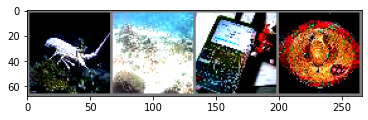

In [10]:
dataiter = iter(val_loader)
images, labels = dataiter.next()
# images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

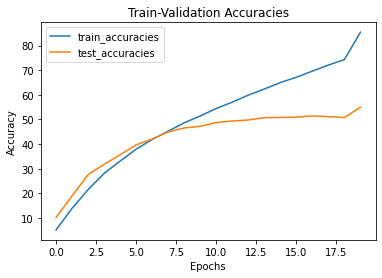

In [11]:
fig, ax = plt.subplots()
ax.plot(train_test_history[20]["train_accuracies"],label="train_accuracies")
ax.plot(train_test_history[20]["test_accuracies"],label="test_accuracies")
leg = ax.legend()
  
plt.title('Train-Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(f'{root_path}/accuracy_plot.png')